# Objectives
* Gain hands on experience working with pyConText and its resources
* Understand and develop Targets
* Understand and develop Modifiers
* Graph and visualize Targets and Modifiers together
* Gain tools for group project in reducing False Negatives and False Positives (F1 measure)

In [3]:
import os

# we will definitely need pyConText
import pyConTextNLP
from pyConTextNLP import pyConTextGraph
from pyConTextNLP.itemData import itemData
from pyConTextNLP.display.html import mark_document_with_html
print(pyConTextNLP.__version__)
# useful utilities in RadNLP as well
import radnlp
import radnlp.view as rview
from radnlp.data import classrslts
# we will need a few other packages
from textblob import TextBlob
import urllib
import pandas as pd
# packages for interaction
from IPython.html.widgets import interact, interactive, fixed
from IPython.display import display, HTML, Image
import ipywidgets
# and also our utilities for this class
from nlp_pneumonia_utils import Annotation
from nlp_pneumonia_utils import AnnotatedDocument
from nlp_pneumonia_utils import read_brat_annotations
from nlp_pneumonia_utils import read_doc_annotations
from nlp_pneumonia_utils import read_annotations
from nlp_pneumonia_utils import calculate_prediction_metrics
from nlp_pneumonia_utils import mark_text
from nlp_pneumonia_utils import clearPyConTextRegularExpressions
from nlp_pneumonia_utils import pneumonia_annotation_html_markup
from nlp_pneumonia_utils import mark_document_with_html
from nlp_pneumonia_utils import view_single_sentence_graph
from nlp_pneumonia_utils import markup_sentence

from pprint import pprint
import xml.dom.minidom as minidom 
import xml.etree.ElementTree as ElementTree
#from pycontext_quiz import identify_target_category
#from pycontext_quiz import file_delimiter_quiz
#from pycontext_quiz import modifier_directionality_quiz
#from pycontext_quiz import second_most_frequent_modifier_quiz

print('Imported pneumonia nlp utilities...')

0.6.2.0
Imported pneumonia nlp utilities...


In [4]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ElementTree.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="\t")

# First thing, let's load our training set

In [5]:
annotated_doc_map = read_doc_annotations('data/training_v2.zip')

# let's also use a simple list of documents as well as this map
annotated_docs = list(annotated_doc_map.values())

print('Total Annotated Documents : {0}'.format(len(annotated_docs)))

Reading annotations from file : data/training_v2.zip
Opening local file : data/training_v2.zip
Total Annotated Documents : 70


### Set up an example document to work with


In [6]:
example_document = """
PORTABLE CHEST:  Comparison made to prior film from X:XX a.m. the same day.
     
The ET tube and nasogastric tube remain in good position. Cardiac and
mediastinal contours are stable. No acute changes are seen within the lung
parenchyma; specifically, there is no evidence of new infiltrate (skin folds
do project over the right lung). No consolidation on either side.

IMPRESSION: No evidence of pneumonia."""

example_sentence = """IMPRESSION: No evidence of pneumonia."""

## Our first goal is to translate pneumonia "keywords"  into pyConText "targets" 
### each target can have:
* Standard form
* Category 
* Additional lexical variants (with regular expressions)

## Before we continue, note that any itemData in pyConText has 4 parts:
1. The literal (e.g. "pneumonia", "pneumoniathorax", "can rule out", "cannot be excluded", etc)
2. The category (e.g. "EVIDENCE_OF_PNEUMONIA")
3. The regular expression (optional) used to capture the literal in the text. If no regular expression is provided, a regular expression is generated literally from the literal.
4. The rule (optional). If the itemData is being used as a modifier, the rule states what direction the modifier operates in the sentence: current valid values are: "forward", the item can modify objects following it in the sentence; "backward", the item can modify objects preceding it in the sentence; or "bidirectional", the item can modify objects preceding and following it in the sentence.

### Additionally, itemData can be instantiated in code or from a file.

#### set up some rules for pyConText for EVIDENCE_OF_PNEUMONIA

* At this moment, we will just set up these "concepts" and we will handle modifiers later
* targetswill look like this: 

```Python
targets = itemData(["literal", "CATEGORY", "regular expression(s)", "empty or forward or backward or bidirectional"])
```
* As a CATEGORY we will use `EVIDENCE_OF_PNEUMONIA`

In [7]:
targets1 = []
modifiers1 = []


targets1 = itemData(["pneumonia", "EVIDENCE_OF_PNEUMONIA", "", ""])

### Use this now on example sentence:

In [8]:
markup = markup_sentence(example_sentence, modifiers1, targets1)
# prettier display with IPython display
display(markup.nodes(data = True))
print(markup.getXML())


[(<id> 322880315917699869357091389547409768457 </id> <phrase> pneumonia </phrase> <category> ['evidence_of_pneumonia'] </category> ,
  {'category': 'target'})]


<ConTextMarkup>
<rawText> IMPRESSION: No evidence of pneumonia. </rawText>
<cleanText> IMPRESSION: No evidence of pneumonia. </cleanText>
<nodes>

<node>
<category> target </category>

<tagObject>
<id> 322880315917699869357091389547409768457 </id>
<phrase> pneumonia </phrase>
<literal> pneumonia </literal>
<category> ['evidence_of_pneumonia'] </category>
<spanStart> 27 </spanStart>
<spanStop> 36 </spanStop>
<scopeStart> 0 </scopeStart>
<scopeStop> 37 </scopeStop>
</tagObject>

</node>

</nodes>
<edges>

</edges>
</ConTextMarkup>



### This function works on entire documents 
### Combine all sentence-level objects into one object we can can then graph

In [19]:
def markup_context_document(report_text, modifiers, targets):
    context = pyConTextGraph.ConTextDocument()
    
    # we will use TextBlob for breaking up sentences
    sentences = [s.raw for s in TextBlob(report_text).sentences]
    for sentence in sentences:
        m = markup_sentence(sentence, modifiers=modifiers, targets=targets)
        context.addMarkup(m)
    
    return context

### Quesiton : Will we find a target match on this sentence? Will we match "pneumonias"?

In [21]:
example_sentence_2 = \
"""Findings consistent with CHF, although underlying bilateral lower lobe pneumonias cannot 
be excluded."""

In [22]:
# let's see how things look on this sentence
markup_sentence_2 = markup_sentence(example_sentence_2, modifiers1, targets1, verbose = True)
display(markup_sentence_2.nodes(data = True))

[]

### So we didn't mark up a target for "pneumonias" 
#### We only had the singular variant "pneumonia". 

### Let's add that as we augment our target concepts

In [23]:
pneumonia_targets_file = 'KB/pneumonia_targets.tsv'

# let's see what we're working with by loading this as a Pandas DataFrame and then we can display it
pneumonia_targets_df = pd.read_csv(pneumonia_targets_file, delimiter = '\t')
display(pneumonia_targets_df)

,Lex,Type,Regex,Direction,Codes
0,pneumonia,EVIDENCE_OF_PNEUMONIA,\bpneumonia[s]?\b,NaN,NaN
1,consolidation,EVIDENCE_OF_PNEUMONIA,NaN,NaN,NaN
2,infiltrate,EVIDENCE_OF_PNEUMONIA,NaN,NaN,NaN


## This time we will augment our targets by modifying a tab-delimited file (.tsv).  A starter TSV file is included in our course resources:
<a href="https://github.com/UUDeCART/decart_rule_based_nlp/blob/master/KB/pneumonia_targets.tsv">KB/pneumonia_targets.tsv</a>

In [24]:
# Our first attempt was very simple targets, so now let's add some additional concepts
targets2 = []
modifiers2 = []

# before we continue, let's clear a mapping of compiled regular expressions which pyConText uses
clearPyConTextRegularExpressions()

# so now let's set this up with more variants of "EVIDENCE_OF_PNEUMONIA"
full_targets_path = 'file:///' + os.path.join(os.getcwd(), pneumonia_targets_file)
print('Loading pneumonia targets from : ' + full_targets_path)
targets2 = pyConTextNLP.itemData.instantiateFromCSVtoitemData(full_targets_path)

# let's go ahead and use this again on our updated targets
context = markup_context_document(example_document, modifiers2, targets2)
# prettier display with IPython display
display(context.getDocumentGraph().nodes(data = True))
#print(context.getXML())

Clearing pyConText compiled regular expressions
Loading pneumonia targets from : file:////home/jovyan/work/anu_masterclass/KB/pneumonia_targets.tsv


[(<id> 149119640121897322813445818796193284105 </id> <phrase> pneumonia </phrase> <category> ['evidence_of_pneumonia'] </category> ,
  {'category': 'target'}),
 (<id> 149119437297801286296741579323680423945 </id> <phrase> infiltrate </phrase> <category> ['evidence_of_pneumonia'] </category> ,
  {'category': 'target'}),
 (<id> 149119549801792056552100962156089901065 </id> <phrase> consolidation </phrase> <category> ['evidence_of_pneumonia'] </category> ,
  {'category': 'target'})]

## Let's look at this markup in HTML with colors

In [25]:
evidence_only_colors = {
    "evidence_of_pneumonia": "orange"
}

context_html = mark_document_with_html(context, colors = evidence_only_colors, default_color="black")
display(HTML(context_html))

### Let's also look again to see if our regular expression for "pneumonia" and "pneumonias" worked properly

In [26]:
markup_sentence_2_check = markup_sentence(example_sentence_2, modifiers2, targets2)
print(targets2)
display(markup_sentence_2_check.nodes(data = True))

itemData: 3 items [pneumonia, consolidation, infiltrate, ]


[(<id> 223835373732104487056356736536959451145 </id> <phrase> pneumonias </phrase> <category> ['evidence_of_pneumonia'] </category> ,
  {'category': 'target'})]

##  We've  added some pyConText targets, so let's utilize them in a classifier 
### so that we can see that adding targets can increase our Recall even if Precision may still be low
* NOTE 1 : We will address Precision in a moment when we start working with ConText Modifiers
* NOTE 2 : You don't need to understand all of the code below.  Essentially, it predicts pneumonia and returns 1 anytime it sees at least one target "EVIDENCE_OF_PNEUMONIA"

In [38]:
class ConTextTargetOnlyClassifier(object):
    def __init__(self, modifiers, targets):
        self.modifiers = modifiers
        self.targets = targets
    def predict(self, text):
        # let's use our other functions in this notebook to perform sentence-wise markup and
        # we can then check to see if these contain any EVIDENCE_OF_PNEUMONIA category types
        context = markup_context_document(text, self.modifiers, self.targets)
        document_graph = context.getDocumentGraph()
        
        # let's walk through all of the nodes in the graph and see how many are evidence of pneumonia
        pneumonia_evidence_count = 0
        for node in document_graph.nodes():
            category_list = node.getCategory()
            for category in category_list:
                if category.upper() == 'EVIDENCE_OF_PNEUMONIA':
                    pneumonia_evidence_count += 1
            
        # do we have at least one category of pneumonia evidence here?
        return (pneumonia_evidence_count) > 0
           
# this one has only one target
classifier1 = ConTextTargetOnlyClassifier(modifiers1, targets1)
# this one has 3...
classifier2 = ConTextTargetOnlyClassifier(modifiers2, targets2)

# and now we can assess their performance
print('****************')
print('Performance for Classifier 1 : One total Target')
calculate_prediction_metrics(annotated_docs, classifier1.predict)

print('****************')
print('Performance for Classifier 2 : 3 total Targets')
calculate_prediction_metrics(annotated_docs, classifier2.predict)

****************
Performance for Classifier 1 : One total Target
Precision : 0.7
Recall :    0.6176470588235294
F1:         0.65625

Confusion Matrix : 


Predicted,False,True
Actual,,
0,27,9
1,13,21


****************
Performance for Classifier 2 : 3 total Targets
Precision : 0.6666666666666666
Recall :    0.8235294117647058
F1:         0.7368421052631577

Confusion Matrix : 


Predicted,False,True
Actual,,
0,22,14
1,6,28


### So we have improved recall, but what are we going to do about Precision?  
#### Since both Precision and Recall are measured equally in our F1 measure, we need to address it.  
#### The solution to this is to improve our classification pipeline with ConText Modifiers
* Modifiers are used to modify other tags or items in the sentence.  For example, we've already added targets for evidence of pneumonia.  We can now use modifiers to treat each of these mentions as affirmed or denied (negated) for a few examples.
* Concretely if we had a sentence "No evidence of pneumonia" our current pipelines would count this as a positive case of pneumonia when it is in fact the contrary.
* We can add a rule "no evidence of" to modify all targets which follow it
* Modifiers can also modify targets which came before it in a sentence such as "pneumonia will be ruled out"

## Modifier Rules can have the following values:
1. backward (modify any markup preceding it)
2. forward (modify any markup following it)
3. bidirectional (modify any markup following or preceding it)

## Let's look at a simple example of a modifier

Clearing pyConText compiled regular expressions


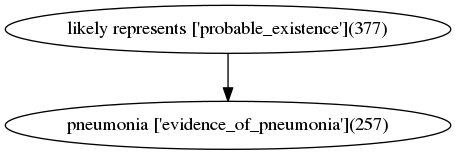

likely represents pneumonia


In [15]:
likely_sentence = """likely represents pneumonia"""

simple_modifiers = itemData(["likely represents", "PROBABLE_EXISTENCE", "", "forward"])

clearPyConTextRegularExpressions()
view_single_sentence_graph(likely_sentence, simple_modifiers, targets1)

## Now let's experiment with the directionality of the modifiers (forward, backward, etc)

In [16]:
probable_sentence_1 = """probable case of pneumonia"""
probable_sentence_2 = """no evidence of pneumonia and probable arthritis"""

In [17]:
   
modifiers_forward = itemData(["probable", "PROBABLE_EXISTENCE", "", "forward"])
modifiers_backward = itemData(["probable", "PROBABLE_EXISTENCE", "", "backward"])

## Let's ee how the forward modifiers work on probable_sentence_1

Clearing pyConText compiled regular expressions


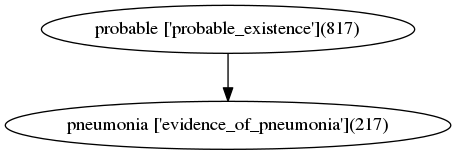

probable case of pneumonia


In [18]:
# let's see how we graph the relationships between targets and modifiers based on 'backward' or 'forward':
clearPyConTextRegularExpressions()
view_single_sentence_graph(probable_sentence_1, modifiers_forward, targets1)

## Assignment: Experiment with the two sentences and the two modifier lists to see how forward and backward work. 

In [ ]:
clearPyConTextRegularExpressions()
#view_single_sentence_graph(probable_sentence_X, modifiers_X, targets1)

## For probable_sentence_2 with modifiers_backward, the modifier has scope over the target, so pyConText would assign the label probable  evidence of pneumonia, which is not correct.

Clearing pyConText compiled regular expressions


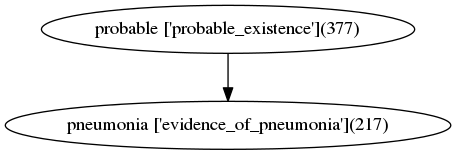

no evidence of pneumonia and probable arthritis


In [25]:
# let's see how we graph the relationships between targets and modifiers based on 'backward' or 'forward':
clearPyConTextRegularExpressions()
view_single_sentence_graph(probable_sentence_2, modifiers_backward, targets1)

## Another important Modifier rule : "terminate"
This allows any modifier working forward or backward to stop its modifications if it encounters one of these terms.  Let's demonstrate an example where we want "probable" to modify "arthritis" as a condition but not "pneumonia":

In [28]:
terminate_example_sentence = """probable arthritis but not pneumonia"""

In [29]:
temp_targets = itemData(["pneumonia", "EVIDENCE_OF_PNEUMONIA", "", ""],
                       ["arthritis", "ANOTHER_CONDITION", "", ""])

modifiers_without_terminate = itemData(["probable", "PROBABLE_EXISTENCE", "", "forward"])

modifiers_with_terminate = itemData(["probable", "PROBABLE_EXISTENCE", "", "forward"],
                                   ["but", "CONJ", "", "terminate"])

### Without the "terminate" modifier, what will "probable_existence" be applied to?

Clearing pyConText compiled regular expressions


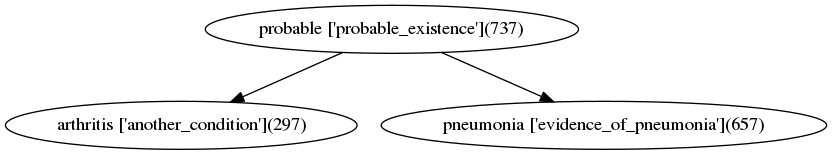

probable arthritis but not pneumonia


In [28]:
clearPyConTextRegularExpressions()
view_single_sentence_graph(terminate_example_sentence, modifiers_without_terminate, temp_targets)

### Here with the "terminate" modifier "probable_existence" is applied only to "arthritis" and does not modify beyond the conjunction "but"

Clearing pyConText compiled regular expressions


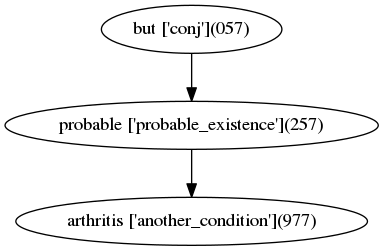

probable arthritis but not pneumonia


In [29]:
clearPyConTextRegularExpressions()
view_single_sentence_graph(terminate_example_sentence, modifiers_with_terminate, temp_targets)

## Developing modifiers takes time and working with a lot of datasets.  
### Luckily, many of them have already been developed on various research efforts.  
### This file contains a subset of these and are a good place to start our group projects:
<a href="https://github.com/UUDeCART/decart_rule_based_nlp/blob/master/KB/pneumonia_modifiers.tsv">KB/pneumonia_modifiers.tsv</a>

In [39]:
modifier_file_path = 'file:///' + os.path.join(os.getcwd(), "KB/pneumonia_modifiers.tsv")
modifier_file = urllib.request.urlopen(modifier_file_path, data=None)
# now let's load this in directly into a DataFrame with Pandas and take a look at it
modifier_df = pd.read_csv(modifier_file, delimiter = "\t")
display(modifier_df.head(5))
display(modifier_df.tail(5))

,Lex,Type,Regex,Direction,Unnamed: 4,Unnamed: 5,Unnamed: 6,Codes
0,are ruled out,DEFINITE_NEGATED_EXISTENCE,NaN,backward,NaN,NaN,NaN,NaN
1,be ruled out,INDICATION,NaN,backward,NaN,NaN,NaN,NaN
2,being ruled out,INDICATION,NaN,backward,NaN,NaN,NaN,NaN
3,can be ruled out,DEFINITE_NEGATED_EXISTENCE,NaN,backward,NaN,NaN,NaN,NaN
4,cannot be excluded,AMBIVALENT_EXISTENCE,NaN,backward,NaN,NaN,NaN,NaN


,Lex,Type,Regex,Direction,Unnamed: 4,Unnamed: 5,Unnamed: 6,Codes
375,suspect,PROBABLE_EXISTENCE,NaN,forward,NaN,NaN,NaN,NaN
376,likely represents,PROBABLE_EXISTENCE,likely (represents|representing),forward,NaN,NaN,NaN,NaN
377,without change,HISTORICAL,NaN,backwards,NaN,NaN,NaN,NaN
378,risk factor,FUTURE,risk factor(s)?,bidirectional,NaN,NaN,NaN,NaN
379,favor,PROBABLE_EXISTENCE,NaN,bidirectional,NaN,NaN,NaN,NaN


## Before we go on, it might be useful to take inventory of all of the modifier categories that are contained within this file since there are dozens of rows.  We'll use Pandas to group by modifier "category" so that we can see what we're working with:

In [31]:
display(modifier_df.groupby('Type').size())

Type
ACUTE                          3
AMBIVALENT_EXISTENCE          27
CONJ                          92
DEFINITE_EXISTENCE            17
DEFINITE_NEGATED_EXISTENCE    72
FUTURE                         8
HISTORICAL                    50
HYPOTHETICAL                   1
INDICATION                    31
PROBABLE_EXISTENCE            29
PROBABLE_NEGATED_EXISTENCE    42
PSEUDONEG                      8
dtype: int64

## Now let's get back to how these are targets and modifiers are used together

In [40]:
modifiers3 = pyConTextNLP.itemData.instantiateFromCSVtoitemData(modifier_file_path)
# let's just use the same targets as above for our third pipeline
targets3 = targets2

clearPyConTextRegularExpressions()

print('Total Modifiers Loaded for pipeline #3 : [{0}]'.format(len(modifiers3)))
print('Total Targets Loaded for pipeline #3 : [{0}]'.format(len(targets3)))

Clearing pyConText compiled regular expressions
Total Modifiers Loaded for pipeline #3 : [380]
Total Targets Loaded for pipeline #3 : [3]


### Use HTML to visualize markups with our document:

In [41]:
# prepare some colors for displaying any markup we might see
colors = {
    "evidence_of_pneumonia": "orange",
    "definite_negated_existence": "red",
    "probable_negated_existence": "indianred",
    "ambivalent_existence": "orange",
    "probable_existence": "forestgreen",
    "definite_existence": "green",
    "historical": "goldenrod",
    "indication": "pink",
    "acute": "golden"
}

# let's mark up a new context object for our pipeline#3
context3 = markup_context_document(example_document, modifiers3, targets3)

display(HTML(mark_document_with_html(context3, colors = colors, default_color="black")))

### Take a closer look at the XML to see how this is working behind the scenes

In [34]:
print(context3.getXML())


<ConTextDocument>
 PORTABLE CHEST: Comparison made to prior film from X:XX a.m. the same day. The ET tube and nasogastric tube remain in good position. Cardiac and mediastinal contours are stable. No acute changes are seen within the lung parenchyma; specifically, there is no evidence of new infiltrate (skin folds do project over the right lung). No consolidation on either side. IMPRESSION: No evidence of pneumonia. <section>
<sectionLabel> document </sectionLabel>
<sentence>
<sentenceNumber> 0 </sentenceNumber>
<sentenceOffset> 0 </sentenceOffset></sentence>

<ConTextMarkup>
<rawText> 
PORTABLE CHEST:  Comparison made to prior film from X:XX a.m. the same day. </rawText>
<cleanText>  PORTABLE CHEST: Comparison made to prior film from X:XX a.m. the same day. </cleanText>
<nodes>

</nodes>
<edges>

</edges>
</ConTextMarkup>
<sentence>
<sentenceNumber> 1 </sentenceNumber>
<sentenceOffset> 76 </sentenceOffset></sentence>

<ConTextMarkup>
<rawText> The ET tube and nasogastric tube remain 

### Process all of the documents and then visualize the relationships between Targets and Modifiers for some of these documents

In [42]:

report_results = []
print('Marking up all documents...')
for anno_doc in annotated_docs:
    report_context = markup_context_document(anno_doc.text, modifiers3, targets3)
    # package this up into a class that the RadNLP utilities can use
    results = classrslts(context_document=report_context, exam_type="Chest X-Ray", report_text=anno_doc.text, classification_result='N/A')
    report_results.append(results)
    
print('DONE Marking up all documents...')

Marking up all documents...
DONE Marking up all documents...


In [43]:
# This function let's us iterate through all documents and view the markup
def view_pycontext_graph(class_results, colors):
    @interact(i=ipywidgets.IntSlider(min=0, max=len(class_results)-1))
    def _view_markup(i):
        class_result = class_results[i]
        rview.markup_to_pydot(class_result)
        display(Image("tmp.png"))
        
        report_html = mark_document_with_html(class_result.context_document, colors = evidence_only_colors, default_color="black")
        
        display(HTML(report_html))
        
# This function let's us iterate through all documents and view the markup
def view_annotation_markup(anno_docs, colors):
    @interact(i=ipywidgets.IntSlider(min=0, max=len(anno_docs)-1))
    def _view_markup(i):
        report_html = pneumonia_annotation_html_markup(anno_docs[i])
        
        display(HTML(report_html))

In [44]:
view_pycontext_graph(report_results, colors)

<br/><br/>This material presented as part of the DeCART Data Science for the Health Science Summer Program at the University of Utah in 2017.<br/>
Presenters : Dr. Wendy Chapman, Jianlin Shi and Kelly Peterson